In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_数据格式_
```
+ 0 0 2 tcp 40 ------- 1 0.0 3.0 0 0
```
1. 动作: “+”：Enqueue；“-”：Dequeue；“r”：Receive；"d"：Drop
2. 时间
3. from_node
4. to_node
5. 封包的类型
6. 封包的大小（单位byte）
7. 标记标注
8. 属于哪个数据流
9. 来源端
10. 目的端
11. sequence number
12. ID

ref: https://blog.csdn.net/yhdyy123/article/details/74027683


In [34]:
file_path = "trace/newreno/5/newreno.tr"

def load_ack(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    ack_seq=[]  #提取含字段 r 2 0的ack帧    
    for line in file_lines:
        line = line.strip().split()
        if line[4] != "ack" or line[2] != '2' or line[3] != '0':
            continue
        ack_seq.append([line[0], float(line[1]), int(line[10])])
        
    return ack_seq

def load_tcp(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    tcp_seq=[]  #提取含字段 r 2 0的ack帧    
    for line in file_lines:
        line = line.strip().split()
        if line[4] != "tcp" or line[2] != '0' or line[3] != '2':
            continue
        tcp_seq.append([line[0], float(line[1]), int(line[10])])
        
    return tcp_seq

def load_cwd(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    cwd_seq=[]  #提取含字段 r 2 0的ack帧    
    for line in file_lines:
        line = line.strip().split()
        if line[5] != "cwnd_":
            continue
        cwd_seq.append([float(line[0]), float(line[6])])
        
    return cwd_seq

ack_seq = load_ack(file_path)
tcp_seq = load_tcp(file_path)
cwd_seq = load_cwd(file_path)
cwd_seq[0:5]

[[0.0, 1.0], [0.1281, 2.0], [0.25792, 3.0], [0.2591, 4.0], [0.38774, 5.0]]

In [64]:
def get_tcp_dequeue(tcp_seq):
    tcp_dequeue_seq = []
    for item in tcp_seq:
        if item[0] != '+':
            continue
        tcp_dequeue_seq.append([item[1], item[2]])
    return np.array(tcp_dequeue_seq)

def get_ack_receive(ack_seq):
    ack_receive_seq = []
    for item in ack_seq:
        if item[0] != 'r':
            continue
        ack_receive_seq.append([item[1], item[2]])
    return np.array(ack_receive_seq)

tcp_dequeue_seq = get_tcp_dequeue(tcp_seq)
ack_receive_seq = get_ack_receive(ack_seq)
print(len(tcp_dequeue_seq), len(ack_receive_seq))

83071 82558


In [72]:
def draw_plot(data1, label1, data2=None, label2=None, plot_title="Plot", save_fig=False):
    fig = plt.figure(figsize=(16,6))
    plt.plot(data1[:,0],data1[:,1],alpha=0.8,color='red',label=label1)
    if data2 is not None:
        plt.plot(data2[:,0],data2[:,1],alpha=0.8,color='blue',label=label2)
    plt.title(plot_title)
    plt.legend(loc='best')
    plt.xlabel("time")
    plt.ylabel("sequence number")
    plt.show()
    if save_fig:
        plt.savefig(plot_title+'.png')


In [49]:
def find_retr(cwd_seq, index_range=20):
    retr_seq = []
    pre = cwd_seq[0]
    for i in range(len(cwd_seq)):
        if pre[1] > cwd_seq[i][1]: #降窗
            retr_seq.extend(cwd_seq[i-index_range:min(i+index_range, len(cwd_seq))])
        pre = cwd_seq[i]
    return  np.array(retr_seq)

retr_seq = find_retr(cwd_seq)

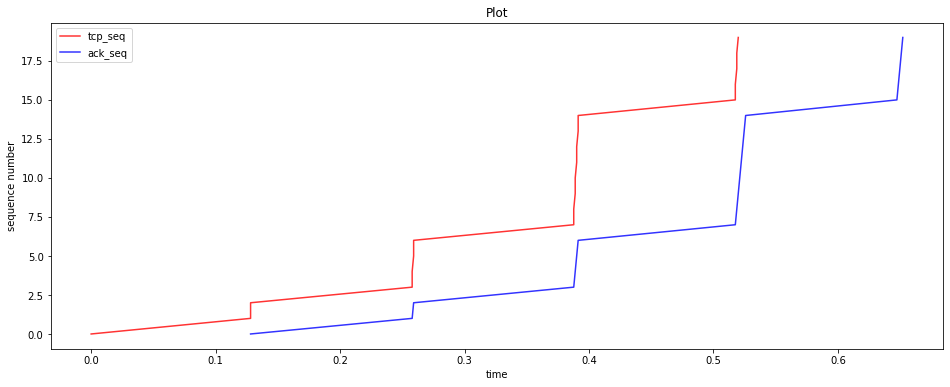

In [73]:
draw_plot(tcp_dequeue_seq[0:20], "tcp_seq", ack_receive_seq[0:20], "ack_seq")